# 회고(코드 길이가 너무 길이서 앞에 작성)

- 총 4번의 모델 구성 및 성능 평가 실시
    - 1) CNN 모델 및 성능 평가
    - 2) resnet18 모델 및 성능평가
    - 3) data agumentation 후 resnet18 모델 및 성능평가
    - 4) data agumentation 후 NN 모델 및 성능 평가

- 첫 번째 모델에서는 나름대로 좋은 성능이 나왔으나(테스트 정확도 82%), 두 번째 모델에서는 수치가 10%나 감소(70%) 하였다.
- resnet18 모델을 제대로 파악하지 못한 상태에서 우격다짐으로 모델을 구성한 탓에 수치가 떨어진 것으로 판단된다.
- 그러나 data agumentation 실시 후 세 번째 실험에서 정확도가 첫 번째 실험과 비슷하게(81%) 나왔다.
- resnet18 모델의 신경망이 깊다보니까, 데이터를 제대로 전처리 및 수정읗 해야 모델에 맞게 적용이 되는 것 같다고 생각하지만, 정확한 분석은 아니다. resnet18의 구조에 대해서 제대로 파악하지 못하고 신경망을 구성한 탓도 큰 것 같다(노드에서 요구한 대로 제대로 구성을 못한 것 같음).
- 네 번째 실험 시도에서도 약 83% 정도 결과 나옴
- 해당 실험 마다 메모리 관리를 위해 해당 모델을 저장 후 삭제, 결과값들은 데이터프레임으로 저장하였다.

- 번외로 마지막 부분에서 이미 학습이 끝난 첫 번째 실험 모델의 conv 레이어의 가중치의 피쳐맵을 확인하는 시도를 하였다
- 피쳐맵이 어떻게 구성되는지, 해당 피쳐맵을 통해 나오는 이미지는 어떤 것인지 파악하기 위해 해당 내용을 수행했다.

# Step 1. Set-up

In [1]:
from tensorflow import keras
import os, re
import random, math
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')

In [2]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE

# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' 
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

print(ROOT_PATH)

/aiffel/aiffel


In [3]:
# 배치 사이즈 및 에폭
BATCH_SIZE = 16
EPOCHS = 10

# Step 2. 데이터 준비하기

## 1) 데이터 수 확인 및 전처리

- 훈련, 검증, 테스트 데이터 수를 확인
- 모델 훈련 및 검정을 위해 훈련, 검증 데이터 수의 비율을 재조정 

In [4]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

# 훈련, 테스트, 검정 데이터 수 확인
print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


In [5]:
# train 데이터와 validation 데이터를 모두 filenames에 할당
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 분배
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

# 훈련, 테스트, 검정 데이터 수 확인
print(len(train_filenames))
print(len(val_filenames))

4185
1047


- 훈련 데이터 가운데 정상 이미지와 폐렴 이미지 수 확인
- 정상 이미지가 폐임 이미지보다 약 3배 많은 것 확인

In [6]:
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/IM-0450-0001.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person1345_bacteria_3422.jpeg


In [7]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1070
Pneumonia images count in training set: 3115


- 미니 배치 작업을 위해 tf.data 인스턴스로 변환

In [8]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

print(train_list_ds)
print(val_list_ds)

<TensorSliceDataset shapes: (), types: tf.string>
<TensorSliceDataset shapes: (), types: tf.string>


In [9]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


## 2) 데이터에 필요한 함수 생성 및 전처리

- 파일 경로에 있는 'NORMAL', 'PNEUMONIA'를 이용해 이미지 라벨 데이터 생성 함수 작성

In [10]:
# 파일 경로의 끝에서 두번째 부분을 확인해 양성과 음성을 구분
# 폐렴이면 양성(True), 노말이면 음성(False)
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"

- 이미지 사이즈 조정을 위해 decode_img 함수 작성
- process_path 함수에서 decode_img 함수를 이용해서 이미지의 데이터 타입을 float으로 바꾸고 사이즈를 변경 
- get_label을 이용해서 라벨 값을 할당

In [11]:
# 이미지를 알맞은 형식으로 변경
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# process_path 함수를 통해 이미지 파일 경로를 입력하면 이미지 로드 및 라벨 할당
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

- map 함수를 사용해 process_path 함수로 훈련 및 검증 데이터 생성
- 데이터 생성 후 이미지 리사이즈 및 라벨 확인

In [12]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [13]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


- 위 과정과 동일하게 테스트 데이터셋 생성

In [14]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [15]:
for image, label in test_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (16, 180, 180, 3)
Label:  [False  True  True  True  True False False False  True  True  True  True
  True False False False]


- tf.data 파이프라인을 이용하여 prepare_for_training() 함수를 정의해서 데이터를 변환
- shuffle()을 사용하며 고정 크기 버퍼를 유지하고 해당 버퍼에서 무작위로 균일하게 다음 요소를 선택
- repeat()를 사용해 여러 번 데이터셋을 사용할 수 있게 함
- batch()를 사용해 BATCH_SIZE에서 정한 만큼의 배치를 할당
- prefetch() 사용해 학습 데이터를 나눠서 읽어 리소스 유휴 상태를 줄이게 함

In [16]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

In [17]:
train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

print(train_ds)
print(val_ds)

<PrefetchDataset shapes: ((None, 180, 180, 3), (None,)), types: (tf.float32, tf.bool)>
<PrefetchDataset shapes: ((None, 180, 180, 3), (None,)), types: (tf.float32, tf.bool)>


# Step 3. 데이터 시각화

- show_batch() 함수를 이용해 train에 있는 batch 중 첫 번째 배치를 추출해서 이미지 확인

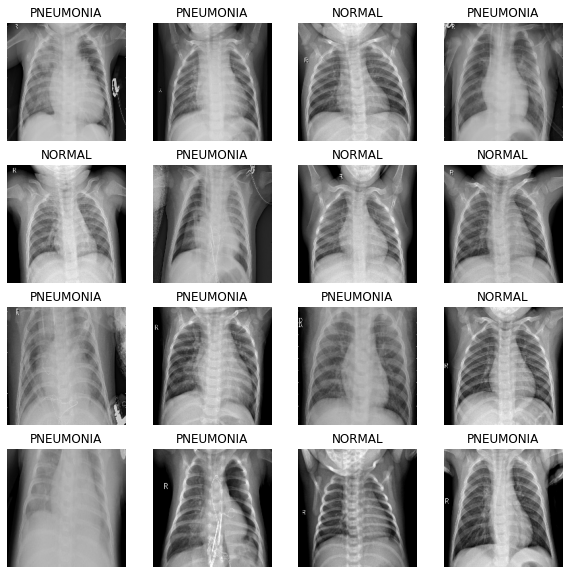

In [19]:
# 이미지 배치를 입력하면 여러장의 이미지를 출력
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

# Step 4. 모델 구현 및 학습(CNN과 ResNet-18 비교)

- 실습 노드의 CNN 모델과 프로젝트 노드의 ResNet-18을 서로 비교함
- 먼저, 실습 노드의 CNN 모델을 구현 후 학습 및 결과 확인
- 다음으로, 프로젝트 노드의 ResNet-18 구현 후 학습 및 결과 확인
- 마지막으로, 두 모델의 성능을 비교할 예정

# Step 4-1 CNN 모델링 및 학습, 결과 확인

## 1) CNN 모델링

- conv_block()의 구성
- Convolution을 두 번 진행 
- Batch Normalization을 통해서 Gradient vanishing, Gradient Exploding을 해결 
- 이후 Max Pooling 실시

In [29]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

- dense 층을 만들기 위핸 dense_block() 구성

In [30]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

- 전체 모델 구성

In [31]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

## 2) 데이터 imbalance 처리

In [24]:
print(f"Normal images count in training set: {COUNT_NORMAL}")
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1072
Pneumonia images count in training set: 3113


- 위에서 보이듯, 정상 이미지는 1072개, 폐렴 이미지는 3113개로 불균형한 상태임
- imbalance한 상태를 해결하기 위해 Weight balancing 사용
- 훈련 데이터셋의 각 데이터셋을 계산할 때 특정 클래스의 데이터에 큰 loss값을 주도록 가중치 할당
- 아래 코드에서 weight_for_0은 'Normal' 이미지에 사용할 weight를, 
- weight_for_1은 'Pneumonia' 이미지에 사용할 weight를 세팅

In [17]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.96
Weight for PNEUMONIA: 0.67


## 3) 모델 훈련

- 이미지 훈련은 GPU를 사용할 것이기 때문에 먼저 GPU를 선택 
- 모델은 위에서 만들었던 모델 함수인 build_model()을 model에 선언
- 이미지의 라벨이 두 개밖에 없기 때문에 "binary_cross entropy" loss를 사용
- optimizer로 'adam'을 사용합니다.
- 성과에 대해서 측정하기 위한 metrics으로 'accuracy', 'precision', 'recall'을 사용

In [32]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )
    
#     check = keras.callbacks.ModelCheckpoint('best-cnn-model.keras')
#     stop = keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)

In [33]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/10
261/261 [==============================] - 66s 214ms/step - loss: 0.3687 - accuracy: 0.8199 - precision: 0.9573 - recall: 0.7933 - val_loss: 0.6837 - val_accuracy: 0.7365 - val_precision: 0.7365 - val_recall: 1.0000
Epoch 2/10
261/261 [==============================] - 57s 218ms/step - loss: 0.2178 - accuracy: 0.9207 - precision: 0.9728 - recall: 0.9193 - val_loss: 1.3494 - val_accuracy: 0.7365 - val_precision: 0.7365 - val_recall: 1.0000
Epoch 3/10
261/261 [==============================] - 58s 221ms/step - loss: 0.1965 - accuracy: 0.9227 - precision: 0.9734 - recall: 0.9210 - val_loss: 0.5377 - val_accuracy: 0.7817 - val_precision: 0.7712 - val_recall: 1.0000
Epoch 4/10
261/261 [==============================] - 58s 222ms/step - loss: 0.1664 - accuracy: 0.9377 - precision: 0.9785 - recall: 0.9370 - val_loss: 0.1349 - val_accuracy: 0.9500 - val_precision: 0.9407 - val_recall: 0.9948
Epoch 5/10
261/261 [==============================] - 58s 222ms/step - loss: 0.1740 - accura

## 4) 성능 평가 및 시각화, 모델 결과 저장

- 'precision', 'recall', 'accuracy', 'loss'의 추이를 그래프로 확인
- 대략 7번째 에폭에서 각 추이들이 특정 변화('precision', 'recall', 'accuracy'은 하락; 'loss'는 상승)했다가 
- 8번째 에폭에서 다시 정상 추이로 돌아가는 게 보이는 것 같음

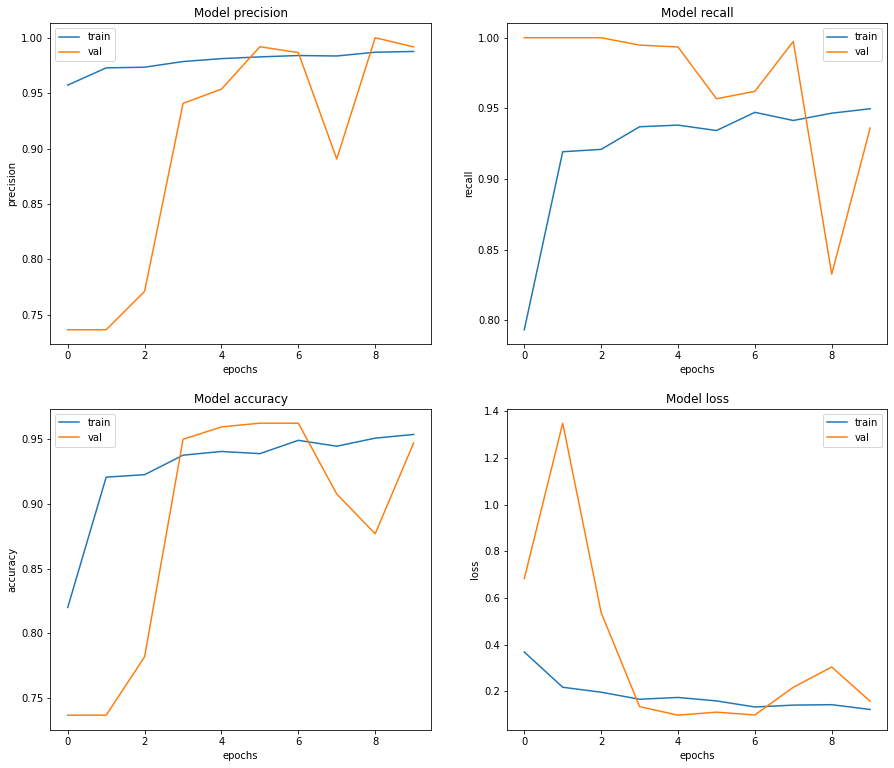

In [34]:
fig, ax = plt.subplots(2, 2, figsize=(15, 13))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

- 테스트 데이터 평가
- 전체적인 수치는 나쁘지 않으나, 특히 재현율 수치가 높게 출력
- 폐렴 환자 식별을 위해 재현율 수치가 높게 나오는 것이 실제 상황에서 제일 중요할 것으로 생각됨
- 그러나 다른 수치들도 재현율만큼 좀 더 높은 수치로 나오게 만들 필요도 있음

In [35]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 4s 113ms/step - loss: 0.6543 - accuracy: 0.8397 - precision: 0.8139 - recall: 0.9641
Loss: 0.6542712450027466,
Accuracy: 0.8397436141967773,
Precision: 0.8138527870178223,
Recall: 0.964102566242218


- 메모리 관리를 위해 해당 기록 데이터프레임 및 모델 저장

In [38]:
model.save('model-cnn.keras')

In [39]:
history_cnn_df = pd.DataFrame(history.history)
history_cnn_df

,loss,accuracy,precision,recall,val_loss,val_accuracy,val_precision,val_recall
0,0.368661,0.819923,0.957265,0.793303,0.683717,0.736538,0.736538,1.000000
1,0.217812,0.920738,0.972780,0.919293,1.349400,0.736538,0.736538,1.000000
2,0.196475,0.922653,0.973406,0.920968,0.537712,0.781731,0.771169,1.000000
3,0.166420,0.937739,0.978509,0.936978,0.134901,0.950000,0.940741,0.994778
4,0.174050,0.940613,0.981132,0.938144,0.098016,0.959615,0.953634,0.993473
5,0.159316,0.938937,0.982724,0.934300,0.111067,0.962500,0.991859,0.956806
6,0.133207,0.949234,0.983941,0.947182,0.099049,0.962500,0.986577,0.962042
7,0.141232,0.944684,0.983524,0.941423,0.217661,0.907692,0.890570,0.997392
8,0.143076,0.950910,0.986917,0.946589,0.304434,0.876923,1.000000,0.832680
9,0.122535,0.953784,0.987601,0.949726,0.157819,0.947115,0.991701,0.936031


In [40]:
# 메모리 관리를 위해 모델 삭제
del model

# Step 4-2 ResNet-18 모델링 및 학습, 결과 확인

In [18]:
from tensorflow.keras.layers import Input, Dropout, Flatten, Conv2D, MaxPooling2D, Dense, BatchNormalization, Activation, Add, GlobalAveragePooling2D
from tensorflow.keras.models import Model

- residual_block 함수
    - Shortcut connection을 위한 함수 작성. 
    - 함수 내부에서는 두 개의 Conv2D 레이어와 BatchNormalization을 사용하여 주 경로를 구성
    - 이후, 스킵 연결(Shortcut connection)을 설정
    - downsample 플래그가 True라면, 주 경로와 스킵 연결의 차원을 맞추기 위해 1x1 Conv2D 레이어를 추가적으로 사용

- build_resnet18 함수
    -  초기 Conv2D 레이어와 MaxPooling2D 레이어를 설정하고, 이후에 residual_block 함수를 사용하여 Residual 블록을 여러 번 쌓음 
    -  다양한 피쳐맵을 뽑아내기 위해 residual_block에서 downsampling을 번걸아가면서 작성
- 이후 과정은 위와 동일

In [19]:
def residual_block(x, filters, downsample=False):
    filters1, filters2 = filters
    
    # Shortcut connection
    shortcut = x
    
    # Main path
    x = Conv2D(filters1, kernel_size=(3, 3), strides=(1, 1), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters2, kernel_size=(3, 3), strides=(1, 1), padding='same')(x)
    x = BatchNormalization()(x)
    
    # Skip connection (Identity mapping)
    if downsample:
        shortcut = Conv2D(filters2, kernel_size=(1, 1), strides=(2, 2), padding='valid')(shortcut)
        shortcut = BatchNormalization()(shortcut)
    
    # Matching dimensions of shortcut and main path
    if downsample:
        x = Conv2D(filters2, kernel_size=(1, 1), strides=(2, 2), padding='valid')(x)
        x = BatchNormalization()(x)
    
    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

def build_resnet18(input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3), num_classes=1):
    input_tensor = Input(shape=input_shape)
    
    # Initial Convolution and Pooling
    x = Conv2D(64, kernel_size=(7, 7), strides=(2, 2), padding='same', kernel_initializer='he_normal')(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)
    
    # Residual blocks
    x = residual_block(x, filters=[64, 64], downsample=True)
    x = residual_block(x, filters=[64, 64], downsample=False)
    
    x = residual_block(x, filters=[128, 128], downsample=True)
    x = residual_block(x, filters=[128, 128], downsample=False)
    x = Dropout(0.3)(x)
    
    x = residual_block(x, filters=[256, 256], downsample=True)
    x = residual_block(x, filters=[256, 256], downsample=False)
    
    x = residual_block(x, filters=[512, 512], downsample=True)
    x = residual_block(x, filters=[512, 512], downsample=False)
    x = Dropout(0.3)(x)
    
    # Global Average Pooling
    x = GlobalAveragePooling2D()(x)
    
    # Fully connected layers
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(64, activation='relu')(x)
    x = Dense(num_classes, activation='sigmoid')(x)
    
    model = Model(inputs=input_tensor, outputs=x)
    return model

# ResNet-18 모델 생성
resnet18_model = build_resnet18()

In [185]:
with tf.device('/GPU:0'):

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    resnet18_model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )
    
#     check = keras.callbacks.ModelCheckpoint('best-cnn-model.keras')
    stop = keras.callbacks.EarlyStopping(patience=5,restore_best_weights=True)

In [186]:
with tf.device('/GPU:0'):
    history = resnet18_model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // 16,
        epochs=10,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // 16,
        class_weight=class_weight,
        callbacks=[stop]
    )

Epoch 1/10
261/261 [==============================] - 64s 202ms/step - loss: 0.2714 - accuracy: 0.9011 - precision: 0.9670 - recall: 0.8976 - val_loss: 0.3809 - val_accuracy: 0.8519 - val_precision: 0.8348 - val_recall: 0.9961
Epoch 2/10
261/261 [==============================] - 53s 204ms/step - loss: 0.1626 - accuracy: 0.9349 - precision: 0.9820 - recall: 0.9295 - val_loss: 0.8865 - val_accuracy: 0.6952 - val_precision: 1.0000 - val_recall: 0.5851
Epoch 3/10
261/261 [==============================] - 53s 205ms/step - loss: 0.1451 - accuracy: 0.9423 - precision: 0.9864 - recall: 0.9352 - val_loss: 2.5629 - val_accuracy: 0.5298 - val_precision: 1.0000 - val_recall: 0.3599
Epoch 4/10
261/261 [==============================] - 55s 212ms/step - loss: 0.1245 - accuracy: 0.9500 - precision: 0.9876 - recall: 0.9447 - val_loss: 0.1330 - val_accuracy: 0.9548 - val_precision: 0.9626 - val_recall: 0.9764
Epoch 5/10
261/261 [==============================] - 56s 215ms/step - loss: 0.0903 - accura

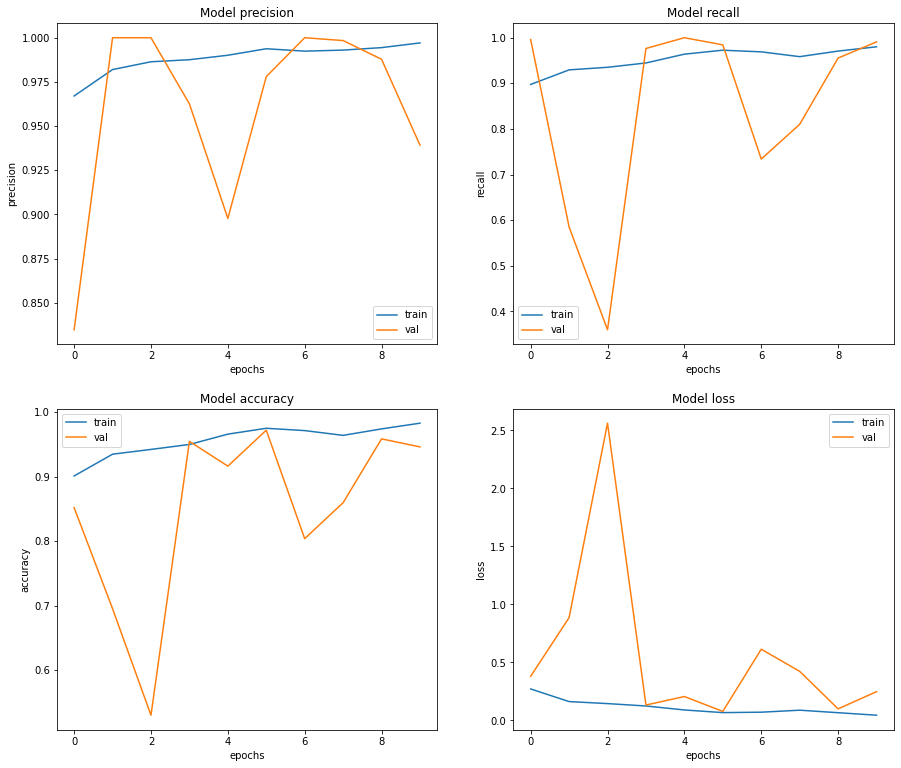

In [187]:
fig, ax = plt.subplots(2, 2, figsize=(15, 13))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [188]:
loss, accuracy, precision, recall = resnet18_model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 5s 123ms/step - loss: 3.4335 - accuracy: 0.7067 - precision: 0.6806 - recall: 1.0000
Loss: 3.43351674079895,
Accuracy: 0.7067307829856873,
Precision: 0.6806282997131348,
Recall: 1.0


In [189]:
history_resnet_df = pd.DataFrame(history.history)
history_resnet_df

,loss,accuracy,precision,recall,val_loss,val_accuracy,val_precision,val_recall
0,0.271364,0.901102,0.967048,0.897618,0.380898,0.851923,0.834792,0.996084
1,0.162620,0.934866,0.981979,0.929514,0.886459,0.695192,1.000000,0.585079
2,0.145148,0.942289,0.986395,0.935182,2.562943,0.529808,1.000000,0.359948
3,0.124536,0.949952,0.987555,0.944659,0.132970,0.954808,0.962581,0.976440
4,0.090350,0.965996,0.990083,0.963952,0.206046,0.916346,0.897767,1.000000
5,0.067463,0.975096,0.993760,0.972678,0.077866,0.972115,0.977979,0.984355
6,0.071053,0.971504,0.992399,0.969022,0.614092,0.803846,1.000000,0.734029
7,0.088295,0.964080,0.992998,0.958481,0.423292,0.859615,0.998387,0.810209
8,0.066607,0.974138,0.994399,0.970730,0.099965,0.958654,0.987805,0.955439
9,0.045145,0.982998,0.997060,0.980090,0.248000,0.946154,0.939206,0.990838


In [191]:
resnet18_model.save('model-resnet.keras')

In [28]:
del resnet18_model

# Step 4-3 ResNet-18 모델링 및 학습(augmentation)

- augmentation만 실시. 모델을 위와 동일

In [20]:
def augment(image, label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전.
    image = tf.image.random_brightness(image, max_delta=0.5)  # 밝기 조절

    return image, label

def prepare_for_training(ds, shuffle_buffer_size=1000):
   
    ds = ds.map(
            augment,       
            num_parallel_calls=2
        )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

In [21]:
train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

In [23]:
with tf.device('/GPU:0'):

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    resnet18_model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )
    
#     check = keras.callbacks.ModelCheckpoint('best-cnn-model.keras')
    stop = keras.callbacks.EarlyStopping(patience=5,restore_best_weights=True)

In [24]:
with tf.device('/GPU:0'):
    history = resnet18_model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // 16,
        epochs=10,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // 16,
        class_weight=class_weight,
        callbacks=[stop]
    )

Epoch 1/10
261/261 [==============================] - 70s 210ms/step - loss: 0.3614 - accuracy: 0.8422 - precision: 0.9477 - recall: 0.8339 - val_loss: 0.3261 - val_accuracy: 0.9058 - val_precision: 0.9256 - val_recall: 0.9475
Epoch 2/10
261/261 [==============================] - 54s 208ms/step - loss: 0.1898 - accuracy: 0.9167 - precision: 0.9812 - recall: 0.9056 - val_loss: 0.4251 - val_accuracy: 0.8760 - val_precision: 0.8731 - val_recall: 0.9725
Epoch 3/10
261/261 [==============================] - 55s 211ms/step - loss: 0.1727 - accuracy: 0.9373 - precision: 0.9820 - recall: 0.9327 - val_loss: 0.1336 - val_accuracy: 0.9500 - val_precision: 0.9810 - val_recall: 0.9501
Epoch 4/10
261/261 [==============================] - 56s 213ms/step - loss: 0.1332 - accuracy: 0.9423 - precision: 0.9851 - recall: 0.9367 - val_loss: 0.2224 - val_accuracy: 0.9356 - val_precision: 0.9212 - val_recall: 0.9974
Epoch 5/10
261/261 [==============================] - 57s 220ms/step - loss: 0.1207 - accura

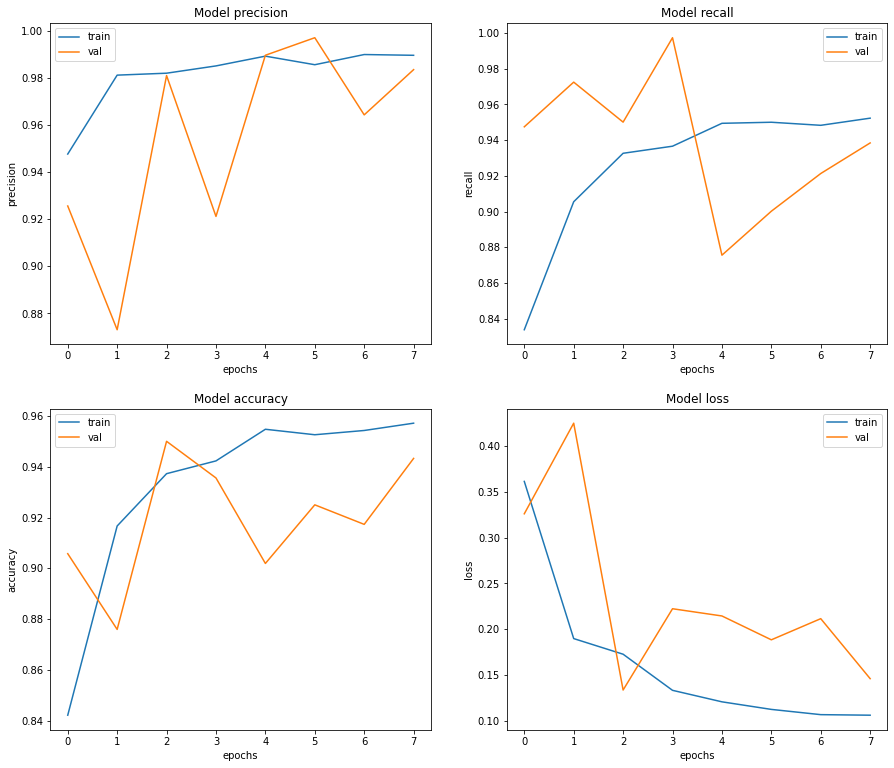

In [25]:
fig, ax = plt.subplots(2, 2, figsize=(15, 13))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [26]:
loss, accuracy, precision, recall = resnet18_model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 5s 123ms/step - loss: 0.6647 - accuracy: 0.8125 - precision: 0.7886 - recall: 0.9564
Loss: 0.6647326350212097,
Accuracy: 0.8125,
Precision: 0.788583517074585,
Recall: 0.9564102292060852


In [27]:
history_resnet_aug_df = pd.DataFrame(history.history)
history_resnet_aug_df

,loss,accuracy,precision,recall,val_loss,val_accuracy,val_precision,val_recall
0,0.361445,0.842193,0.947696,0.833923,0.326065,0.905769,0.925641,0.947507
1,0.189755,0.916667,0.981204,0.905557,0.425050,0.875962,0.873091,0.972513
2,0.172684,0.937261,0.982028,0.932689,0.133564,0.950000,0.981030,0.950131
3,0.133232,0.942289,0.985120,0.936656,0.222351,0.935577,0.921212,0.997375
4,0.120677,0.954741,0.989269,0.949469,0.214465,0.901923,0.989645,0.875654
5,0.112400,0.952586,0.985628,0.950064,0.188408,0.925000,0.997093,0.900262
6,0.106665,0.954262,0.989953,0.948348,0.211515,0.917308,0.964335,0.921363
7,0.106064,0.957136,0.989629,0.952350,0.145984,0.943269,0.983539,0.938482


# Step 4-4 CNN 모델링 및 학습(augmentation)

- 위 cnn 모델과 동일
- 데이터만 augmentation한 것 사용

In [32]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )
    
#     check = keras.callbacks.ModelCheckpoint('best-cnn-model.keras')
#     stop = keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)

In [33]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/10
261/261 [==============================] - 65s 209ms/step - loss: 0.8411 - accuracy: 0.5120 - precision: 0.7596 - recall: 0.5040 - val_loss: 0.8879 - val_accuracy: 0.2644 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/10
261/261 [==============================] - 55s 209ms/step - loss: 0.4503 - accuracy: 0.7625 - precision: 0.9412 - recall: 0.7262 - val_loss: 0.6700 - val_accuracy: 0.7317 - val_precision: 0.7317 - val_recall: 1.0000
Epoch 3/10
261/261 [==============================] - 55s 212ms/step - loss: 0.2990 - accuracy: 0.8736 - precision: 0.9647 - recall: 0.8616 - val_loss: 0.6007 - val_accuracy: 0.7375 - val_precision: 0.7360 - val_recall: 1.0000
Epoch 4/10
261/261 [==============================] - 56s 213ms/step - loss: 0.2546 - accuracy: 0.8920 - precision: 0.9670 - recall: 0.8852 - val_loss: 0.1868 - val_accuracy: 0.9298 - val_precision: 0.9805 - val_recall: 0.9228
Epoch 5/10
261/261 [==============================] - 56s 215ms/step - loss: 0.2612 

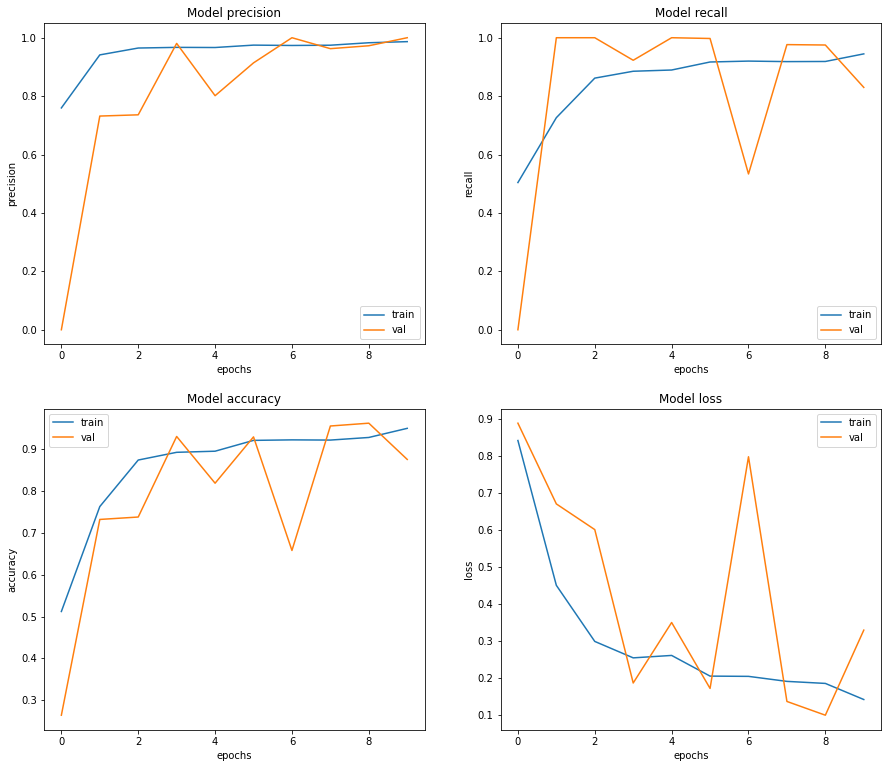

In [35]:
fig, ax = plt.subplots(2, 2, figsize=(15, 13))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [37]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 5s 119ms/step - loss: 0.4361 - accuracy: 0.8333 - precision: 0.8907 - recall: 0.8359
Loss: 0.436076283454895,
Accuracy: 0.8333333134651184,
Precision: 0.8907103538513184,
Recall: 0.8358974456787109


In [38]:
history_cnn2_df = pd.DataFrame(history.history)
history_cnn2_df

,loss,accuracy,precision,recall,val_loss,val_accuracy,val_precision,val_recall
0,0.841080,0.511973,0.759573,0.504021,0.887851,0.264423,0.000000,0.000000
1,0.450311,0.762452,0.941201,0.726190,0.670009,0.731731,0.731731,1.000000
2,0.298985,0.873563,0.964697,0.861647,0.600708,0.737500,0.735977,1.000000
3,0.254650,0.892002,0.966971,0.885172,0.186826,0.929808,0.980529,0.922775
4,0.261181,0.894636,0.966469,0.889425,0.350038,0.818269,0.801471,1.000000
5,0.205391,0.920498,0.974658,0.916881,0.172153,0.928846,0.913876,0.997389
6,0.204712,0.921695,0.973469,0.919961,0.797269,0.657692,1.000000,0.533421
7,0.191187,0.921216,0.974368,0.918196,0.137015,0.954808,0.962532,0.976409
8,0.185672,0.927443,0.982800,0.918649,0.099923,0.961538,0.972477,0.975033
9,0.142235,0.949234,0.986564,0.944677,0.329465,0.875000,1.000000,0.829843


# 번외. 모델의 가중치 피쳐맵 확인

- conv2d를 통해 만들어진 피쳐맵을 확인하고 싶어서 실시
- 시간이 없어 첫 번째 실험 모델인 cnn의 첫 레이어만 확인
- 해당 피쳐맵은 이미 학습된 모델의 레이어 피쳐맵임

In [39]:
# 모델 로드
model = keras.models.load_model('best-cnn-model.keras')

In [40]:
model.layers

In [44]:
# 첫 레이어의 가중치만 떼어서 변수 지정
conv = model.layers[1]

In [47]:
print(conv.weights[0].shape, conv.weights[1].shape)

(3, 3, 16, 16) (16,)


In [48]:
conv_weights = conv.weights[0].numpy()

In [53]:
conv_weights.shape

(3, 3, 16, 16)

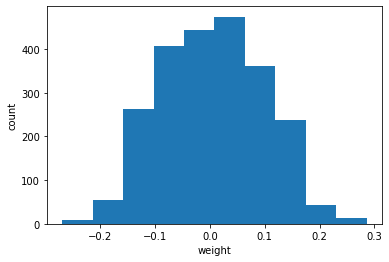

In [49]:
# conv레이어 층의 가중치 분포 확인
plt.hist(conv_weights.reshape(-1, 1))
plt.xlabel('weight')
plt.ylabel('count')
plt.show()

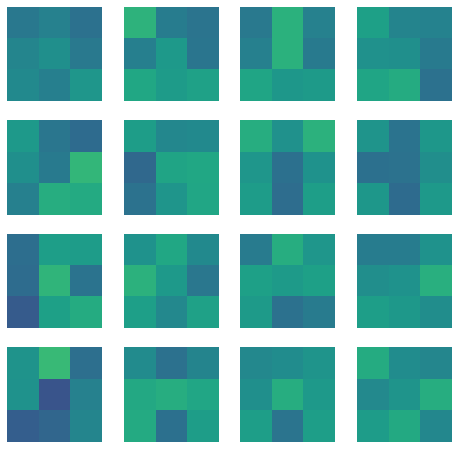

In [63]:
# 선택한 필터 번호
selected_filter = 0  # 예시로 첫 번째 필터 선택

# 해당 필터의 16개의 3x3 가중치를 시각화
fig, axs = plt.subplots(4, 4, figsize=(8, 8))
for i in range(4):
    for j in range(4):
        weight_idx = i * 4 + j  # 가중치 인덱스 계산
        axs[i, j].imshow(conv_weights[:, :, weight_idx, selected_filter], vmin=-0.5, vmax=0.5)
        axs[i, j].axis('off')

plt.show()

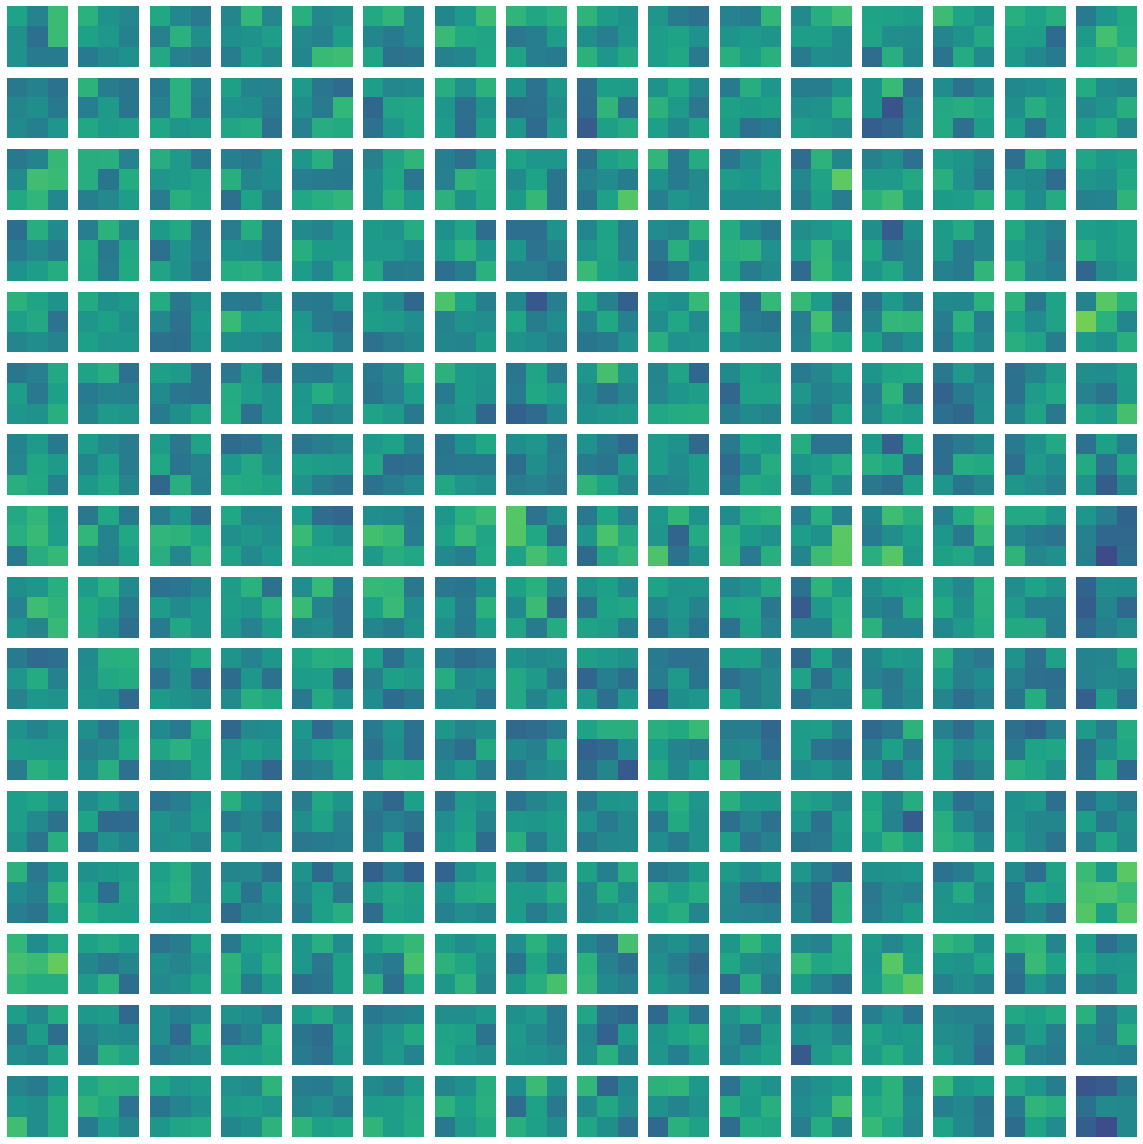

In [64]:
# 모든 필터에 대해 3x3 가중치를 시각화
fig, axs = plt.subplots(16, 16, figsize=(16, 16))
for i in range(16):
    for j in range(16):
        axs[i, j].imshow(conv_weights[:, :, j, i], vmin=-0.5, vmax=0.5)
        axs[i, j].axis('off')

plt.tight_layout()
plt.show()

In [68]:
# input 데이터 추출을 위해 2개의 레이어 연결
conv_acti = keras.Model(model.input, model.layers[1].output)

In [86]:
# input 데이터(1개 데이터) 변수 지정 
inputs = first_element[0]

In [87]:
# input 데이터 스케일 확인
inputs

<tf.Tensor: shape=(16, 180, 180, 3), dtype=float32, numpy=
array([[[[0.5426064 , 0.5426064 , 0.5426064 ],
         [0.27099782, 0.27099782, 0.27099782],
         [0.23257446, 0.23257446, 0.23257446],
         ...,
         [0.43498632, 0.43498632, 0.43498632],
         [0.46549106, 0.46549106, 0.46549106],
         [0.43730596, 0.43730596, 0.43730596]],

        [[0.7224466 , 0.7224466 , 0.7224466 ],
         [0.42471904, 0.42471904, 0.42471904],
         [0.24861656, 0.24861656, 0.24861656],
         ...,
         [0.45715606, 0.45715606, 0.45715606],
         [0.47890913, 0.47890913, 0.47890913],
         [0.31724358, 0.31724358, 0.31724358]],

        [[0.6039797 , 0.6039797 , 0.6039797 ],
         [0.70534855, 0.70534855, 0.70534855],
         [0.31944448, 0.31944448, 0.31944448],
         ...,
         [0.46991748, 0.46991748, 0.46991748],
         [0.45286873, 0.45286873, 0.45286873],
         [0.24535185, 0.24535185, 0.24535185]],

        ...,

        [[0.        , 0.        ,

In [89]:
# 첫번쨰 데이터의 predict 확인
feature_map = conv_acti.predict(inputs)

In [90]:
feature_map.shape

(16, 180, 180, 16)

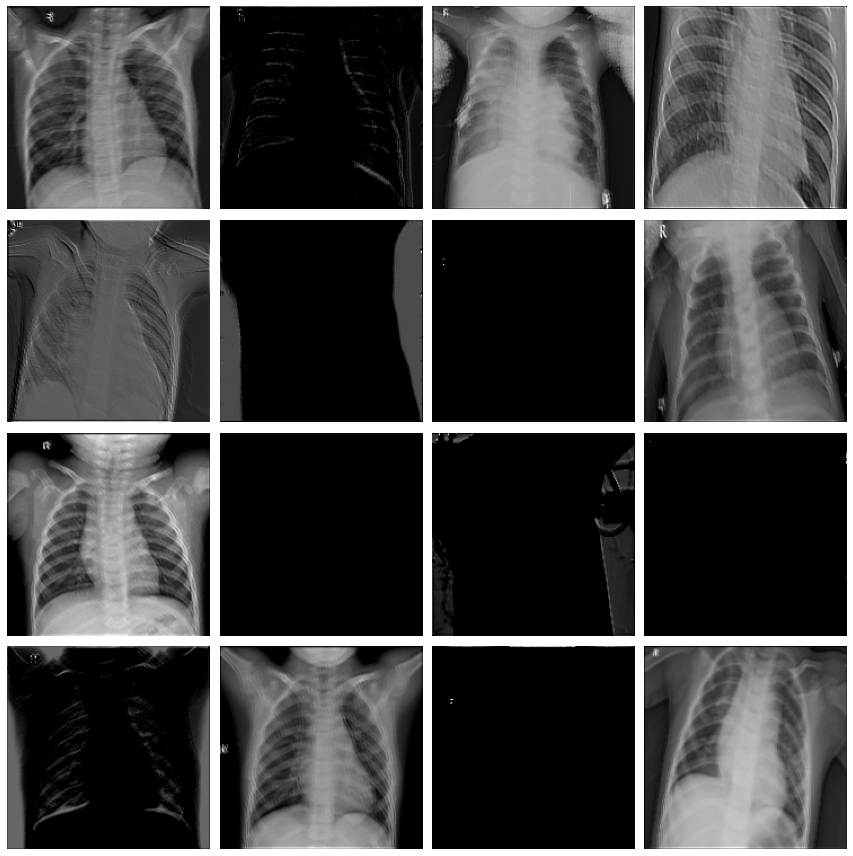

In [92]:
# 16개의 채널을 시각화하기 위해 가로로 나란히 배치
num_channels = feature_map.shape[0]

# 4x4 그리드로 시각화
num_rows = 4
num_cols = num_channels // num_rows

fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 12))

for i in range(num_rows):
    for j in range(num_cols):
        channel_idx = i * num_cols + j
        axs[i, j].imshow(feature_map[channel_idx, :, :, channel_idx], cmap='gray')
        axs[i, j].axis('off')

plt.tight_layout()
plt.show()